# Predicting House Prices

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings
from sklearn import linear_model
import statsmodels.api as sm

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [3]:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [4]:
# dataframe.size 
size = df.size 
  
# dataframe.shape 
shape = df.shape 
  
# dataframe.ndim 
df_ndim = df.ndim 
  
# series.ndim 
series_ndim = df["saleprice"].ndim 
  
# printing size and shape 
print("Size = {}\nShape ={}\nShape[0] x Shape[1] = {}". 
format(size, shape, shape[0]*shape[1])) 
  
# printing ndim 
print("ndim of dataframe = {}\nndim of series ={}". 
format(df_ndim, series_ndim)) 

Size = 118260
Shape =(1460, 81)
Shape[0] x Shape[1] = 118260
ndim of dataframe = 2
ndim of series =1


## Investigate the data, and do any necessary data cleaning.

In [57]:
df.info()
#df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 86 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [6]:
# Discover Non-numeric variables

non_numeric_columns = df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 43


In [7]:
# Discover Numeric variables

numeric_columns = df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 38


## Is there missing data?

In [8]:
total_missing = df.isnull().sum().sort_values(ascending=False)
percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


## Explore the data and find some variables that  would be useful in predicting house prices.

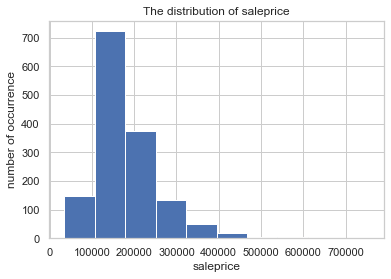

In [9]:
plt.hist(df.saleprice)
plt.title("The distribution of saleprice")
plt.xlabel("saleprice")
plt.ylabel("number of occurrence")
plt.show()

In [10]:
np.abs(df[numeric_columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

## 5 most corrilated variable:

    overallqual      
    grlivarea        
    garagecars       
    garagearea       
    totalbsmtsf

## Feature engineering

In [7]:
# Apply one-way winsorization to the highest end
# of the value distribution. As we have a lot of extreme
# values, we set the values of the outliers to the 
# value of the 90th percentile. 

df["winsorized_saleprice"] = winsorized_saleprice = winsorize(df["saleprice"], (0, 0.10))
df["winsorized_overallqual"] = winsorized_overallqual = winsorize(df["overallqual"], (0, 0.10))
df["winsorized_grlivarea"] = winsorized_grlivarea = winsorize(df["grlivarea"], (0, 0.10))
df["winsorized_garagecars"] = winsorized_garagecars = winsorize(df["garagecars"], (0, 0.10))
df["winsorized_garagearea"] = winsorized_garagearea = winsorize(df["garagearea"], (0, 0.10))
df["winsorized_totalbsmtsf"] = winsorized_totalbsmtsf = winsorize(df["totalbsmtsf"], (0, 0.10))

## Building initial model using features

In [18]:
X = df[['winsorized_overallqual', 'winsorized_grlivarea', 'winsorized_garagecars', 'winsorized_garagearea', 'winsorized_totalbsmtsf']]
Y = df.winsorized_saleprice

In [19]:
X2 = sm.add_constant(X)

results = sm.OLS(Y, X2).fit()

print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     winsorized_saleprice   R-squared:                       0.821
Model:                              OLS   Adj. R-squared:                  0.820
Method:                   Least Squares   F-statistic:                     1329.
Date:                  Thu, 29 Aug 2019   Prob (F-statistic):               0.00
Time:                          13:42:39   Log-Likelihood:                -16838.
No. Observations:                  1460   AIC:                         3.369e+04
Df Residuals:                      1454   BIC:                         3.372e+04
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const   

# Making predictions

### Split data into train and test sets.

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


### Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.

In [21]:
# Add constant to the model.
X_train = sm.add_constant(X_train)

# Fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# Print the summary results
print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     winsorized_saleprice   R-squared:                       0.823
Model:                              OLS   Adj. R-squared:                  0.822
Method:                   Least Squares   F-statistic:                     1082.
Date:                  Thu, 29 Aug 2019   Prob (F-statistic):               0.00
Time:                          13:42:46   Log-Likelihood:                -13456.
No. Observations:                  1168   AIC:                         2.692e+04
Df Residuals:                      1162   BIC:                         2.695e+04
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const   

# Predict the house prices in the test set, and evaluate the performance of model.

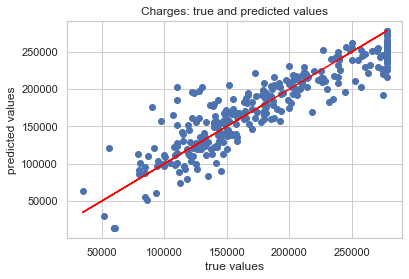

Mean absolute error of the prediction is: 19525.69447490115
Mean squared error of the prediction is: 673568847.0890914
Root mean squared error of the prediction is: 25953.204948312094
Mean absolute percentage error of the prediction is: 13.456026263684715


In [22]:
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

# Add constant to the model
X_test = sm.add_constant(X_test)

# making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))



# Test for overfitting and regularization

#### Lasso regression model

In [23]:
from sklearn.linear_model import Lasso

lassoregr = Lasso() 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.823164557094885
-----Test set statistics-----
R-squared of the model on the test set is: 0.8091119478595393
Mean absolute error of the prediction is: 19525.79291934661
Mean squared error of the prediction is: 673572847.3597137
Root mean squared error of the prediction is: 25953.282015184777
Mean absolute percentage error of the prediction is: 13.456116991071227


(0.0001, 0.31622776601683794)

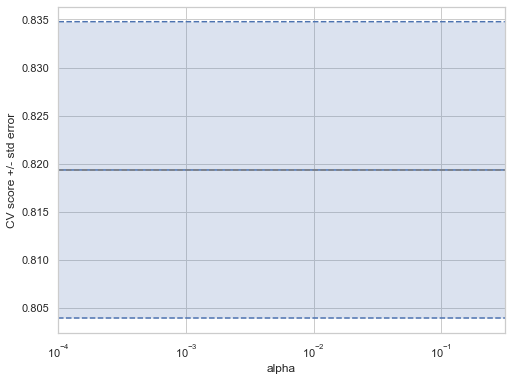

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

lasso = Lasso(random_state=0, max_iter=10000)
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(X_train, y_train)

scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

# Extra-dataset facts to consider

The dataset here includes homes sold bewtween the years of 2006 and 2010.

There was a housing market crash the peaked (crashed and burned) in December 2008.

Let's look a little into the dataset minus homes sold in 2009 and see if we can better predict without.

In [25]:
df2 = df[df['yrsold'] != 2009]

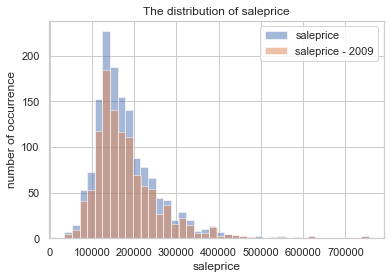

In [26]:
plt.hist(df.saleprice, alpha=0.5, bins=40)
plt.hist(df2.saleprice, alpha=0.5, bins=40)
plt.title("The distribution of saleprice")
plt.legend(["saleprice", "saleprice - 2009"])
plt.xlabel("saleprice")
plt.ylabel("number of occurrence")
plt.show()

In [27]:
# Apply one-way winsorization to the highest end
# of the value distribution. As we have a lot of extreme
# values, we set the values of the outliers to the 
# value of the 90th percentile. 

df2["winsorized_saleprice"] = winsorized_saleprice = winsorize(df2["saleprice"], (0, 0.10))
df2["winsorized_overallqual"] = winsorized_overallqual = winsorize(df2["overallqual"], (0, 0.10))
df2["winsorized_grlivarea"] = winsorized_grlivarea = winsorize(df2["grlivarea"], (0, 0.10))
df2["winsorized_garagecars"] = winsorized_garagecars = winsorize(df2["garagecars"], (0, 0.10))
df2["winsorized_garagearea"] = winsorized_garagearea = winsorize(df2["garagearea"], (0, 0.10))
df2["winsorized_totalbsmtsf"] = winsorized_totalbsmtsf = winsorize(df2["totalbsmtsf"], (0, 0.10))

In [28]:
X7 = df2[['winsorized_overallqual', 'winsorized_grlivarea', 'winsorized_garagecars', 'winsorized_garagearea', 'winsorized_totalbsmtsf']]
Y7 = df2.winsorized_saleprice

In [29]:
X7 = sm.add_constant(X7)

results = sm.OLS(Y7, X7).fit()

print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     winsorized_saleprice   R-squared:                       0.823
Model:                              OLS   Adj. R-squared:                  0.823
Method:                   Least Squares   F-statistic:                     1041.
Date:                  Thu, 29 Aug 2019   Prob (F-statistic):               0.00
Time:                          13:45:10   Log-Likelihood:                -12928.
No. Observations:                  1122   AIC:                         2.587e+04
Df Residuals:                      1116   BIC:                         2.590e+04
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const   

## Making predicitions

In [30]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X7, Y7, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train2.shape[0]))
print("The number of observations in test set is {}".format(X_test2.shape[0]))

The number of observations in training set is 897
The number of observations in test set is 225


## Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.

In [31]:
# Add constant to the model.
X_train2 = sm.add_constant(X_train2)

# Fit an OLS model using statsmodels
results = sm.OLS(y_train2, X_train2).fit()

# Print the summary results
print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     winsorized_saleprice   R-squared:                       0.821
Model:                              OLS   Adj. R-squared:                  0.820
Method:                   Least Squares   F-statistic:                     816.6
Date:                  Thu, 29 Aug 2019   Prob (F-statistic):               0.00
Time:                          13:45:18   Log-Likelihood:                -10338.
No. Observations:                   897   AIC:                         2.069e+04
Df Residuals:                       891   BIC:                         2.072e+04
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const   

## Let's predict now using the new model

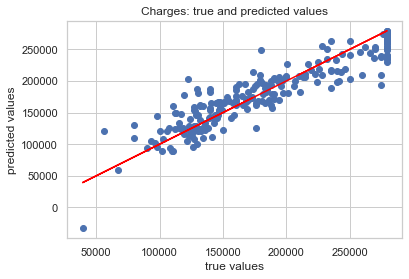

Mean absolute error of the prediction is: 18307.859365980745
Mean squared error of the prediction is: 588607163.169031
Root mean squared error of the prediction is: 24261.227569293173
Mean absolute percentage error of the prediction is: 12.006905886039956


In [32]:
# Add constant to the model
X_test2 = sm.add_constant(X_test2)

# making predictions here
y_preds2 = results.predict(X_test2)

plt.scatter(y_test2, y_preds2)
plt.plot(y_test2, y_test2, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test2, y_preds2)))
print("Mean squared error of the prediction is: {}".format(mse(y_test2, y_preds2)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test2, y_preds2)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test2 - y_preds2) / y_test2)) * 100))

(0.0001, 0.31622776601683794)

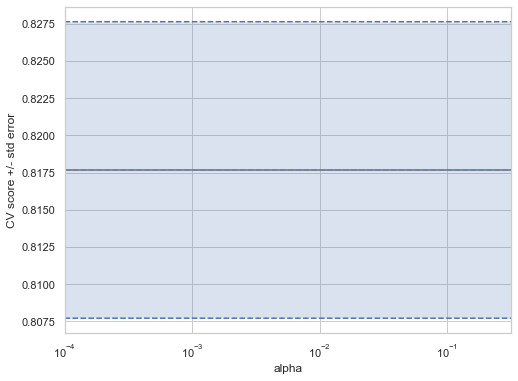

In [39]:
lasso = Lasso(random_state=0, max_iter=10000)
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf2 = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf2.fit(X_train2, y_train2)

scores = clf2.cv_results_['mean_test_score']
scores_std = clf2.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

## It seems that taking the data from the homes sold in 2009 tightens up the models ability to predict!